In [1]:
import numpy as np
np.random.seed(254)
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from pathlib import Path

In [2]:
########################################################
# Read GSR values from CSV and convert to henergy
########################################################
def csv2gsr(location,year,SMAX):
    # Get data from CSV
    #####################
    # solar_data/CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
    # weather_data/CSV files contain the weather summary from 06:00 to 18:00 and 18:00 to 06:00+1

    sfile = Path.cwd() / 'solar_data' / location / (str(year) + '.csv')

    # skiprows=4 to remove unnecessary title texts
    # usecols=4 to read only the Global Solar Radiation (GSR) values
    solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])

    # convert dataframe to numpy array
    solar_radiation = solar_radiation.values

    # convert missing data in CSV files to zero
    solar_radiation[np.isnan(solar_radiation)] = 0

    # reshape solar_radiation into no_of_daysxREADINGS_PER_DAY array
    solar_radiation = solar_radiation.reshape(1,-1).flatten() # 1-D array
    henergy = solar_radiation/SMAX # normalize
    return henergy
########################################################

########################################################
# Class for Energy Prediction
########################################################
class rolling_predictor(object):
        def __init__(self, PREDICTION_HORIZON, PENERGY_NOISE):
            self.PREDICTION_HORIZON = PREDICTION_HORIZON
            self.PENERGY_NOISE = PENERGY_NOISE
            
        def get_prediction(self, henergy_stream):
            PREDICTION_HORIZON = self.PREDICTION_HORIZON
            PENERGY_NOISE = self.PENERGY_NOISE
          # this uses a simple rolling average over a given prediction horizon
            weights = np.ones(PREDICTION_HORIZON) / PREDICTION_HORIZON
            penergy = np.convolve(henergy_stream, weights, mode='same')
            penergy_noise = np.random.normal(0,PENERGY_NOISE,size=penergy.shape) # add noise
            penergy += penergy_noise
#             penergy /= penergy.max()
            penergy_stream = penergy.reshape(1,-1).flatten() # flattened list of penergy
            return penergy_stream
# End of rolling_predictor
########################################################
    
########################################################
# Class for solar energy harvester
########################################################
class csv_solar_harvester(object):
    def __init__(self, 
                 location='wakkanai',
                 year=1995,
                 READINGS_PER_DAY = 24,
                 SMAX=4.0, # Max GSR
                 HENERGY_NOISE=0.1, # henergy artifical noise
                 NORMALIZED_HMIN_THRES=1E-5, # henergy cutoff
                 REQ_TIMESLOTS_PER_DAY=240, # no. of timeslots per day
                 PREDICTION_HORIZON=240, # lookahead horizon to predict energy
                 PENERGY_NOISE=0.005): # preidction noise
        
      
        # Initialize variables
        self.day = 0
        self.global_time = 0
        self.henergy_stream = []
        self.penergy_stream = []
        
        henergy = csv2gsr(location,year,SMAX)
        henergy = henergy.reshape(-1, READINGS_PER_DAY)
        # Fix time resolution
        ######################
        self.no_of_days = int(henergy.shape[0]/READINGS_PER_DAY) # the number of days worth of data in the csv file

        # Interpolate the harvested energy data to new time resolution
        ###############################################################
        itp_henergy = interp1d(np.arange(READINGS_PER_DAY),
                               henergy, 
                               kind='quadratic') # quadratic interpolation
        
        new_time_slots =  np.linspace(0, READINGS_PER_DAY-1, REQ_TIMESLOTS_PER_DAY) # new time index
        high_res_henergy = itp_henergy(new_time_slots) # interpolate and fill in the intermediate values
        self.time_slots = new_time_slots # to access from object instance
    
        # Add noise to henergy data
        ###########################
        henergy_noise = np.random.normal(1,HENERGY_NOISE,size=high_res_henergy.shape) # add some noise to it
        high_res_henergy *= henergy_noise # we multiply so that zero energy times slots remain with zero energy
        high_res_henergy[high_res_henergy<NORMALIZED_HMIN_THRES]=0 # clipping threshold
        high_res_henergy[high_res_henergy>1]=1
        self.henergy_stream = high_res_henergy.reshape(1,-1).flatten().tolist() # flattened list of henergy

        # Get energy prediction
        #######################
        self.predictor = rolling_predictor(PREDICTION_HORIZON, PENERGY_NOISE)
        self.penergy_stream = self.predictor.get_prediction(self.henergy_stream)
        self.penergy_stream[self.penergy_stream<NORMALIZED_HMIN_THRES]=0 # clipping threshold
        self.penergy_stream = self.penergy_stream.tolist()
    
    # step through each time step and output time, henergy, penergy
    def step(self):
        if self.global_time < len(self.henergy_stream):
            HARVESTER_END = False
            DAY_END = False
            time = self.time_slots[self.global_time%len(self.time_slots)]
            henergy = self.henergy_stream[self.global_time]
            penergy = self.penergy_stream[self.global_time]
            
            self.global_time += 1 # new time
            if self.global_time%len(self.time_slots)==0: #new day
#                 print("NEW DAY STARTS:", self.day)
                self.day += 1
                DAY_END = True # this means the next time step is for a new day
            if self.global_time >= len(self.henergy_stream):
#                 print("END OF YEAR. DAY:",self.day)
                HARVESTER_END = True
            return time, henergy, penergy, DAY_END, HARVESTER_END
        else:
            print("YEAR ALREADY ENDED")
            DAY_END = True
            HARVESTER_END = True
            return -1,-1,-1,NEW_DAY, HARVESTER_END
# End of csv_solar_harvester
########################################################

In [3]:
# Get data for all years and store in a dictionary
annual_htrace = {}
annual_ptrace = {}
annual_hmean = {}



for yr in range(1995,2019):
    harvester = csv_solar_harvester(location='wakkanai', 
                                    year=yr,
                                    HENERGY_NOISE=0.0,
                                    PREDICTION_HORIZON=240*10, # lookahead horizon to predict energy
                                    PENERGY_NOISE=0.000)
    done = False
    htrace=[]
    ptrace=[]
    while not done:
        _,henergy,penergy,_,done = harvester.step()
        htrace.append(henergy)
        ptrace.append(penergy)
    annual_hmean[yr] = np.mean(htrace)
    annual_htrace[yr] = htrace
    annual_ptrace[yr] = ptrace

In [4]:
#annual_xtrace[schm][yr] contains the trace of x variable for year=yr when using scheme=schm

annual_rq_trace = {}
annual_prq_trace = {} # predicted request trace. Assuming non-causal information
annual_btrace = {}
annual_dc_trace = {}
annual_mismatch = {}
annual_utrace = {}
annual_umean = {}

scheme_list = ['best','const','random', 'normal', 'uniform', 'random_day']
for scheme in scheme_list:
    annual_rq_trace[scheme] = {}
    annual_prq_trace[scheme] = {}
    annual_btrace[scheme] = {}
    annual_dc_trace[scheme] = {}
    annual_mismatch[scheme] = {}
    annual_utrace[scheme] = {}
    annual_umean[scheme]={}

In [5]:
# Generate requests using different schemes
hmean_10yr = np.mean(list(annual_hmean.values()))
mindc = 0.1
for yr in range(1995,2019):
    htrace = np.array(annual_htrace[yr])
    hmean = hmean_10yr
    
    # Best energy matching between suppy and request
    best_rq_trace = htrace.copy()
    best_rq_trace = mindc + best_rq_trace * (hmean-mindc)/(hmean)
    annual_rq_trace['best'][yr] = best_rq_trace
    
    # Constant request
    const_rq_trace = np.ones_like(htrace)*hmean
    annual_rq_trace['const'][yr] = const_rq_trace


    # Request is a random timeslot
    random_rq_trace = best_rq_trace.copy()
    np.random.shuffle(random_rq_trace)
    annual_rq_trace['random'][yr] = random_rq_trace
    
    # Request is a normally distributed with mean=hmean
    n_samples = len(htrace)
    amin, amax = 0, 1
    samples = np.zeros((0,))    # empty for now
    while samples.shape[0] < n_samples: 
        s = np.random.normal(loc=hmean,scale=0.1, size=(n_samples,))
        accepted = s[(s >= amin) & (s <= amax)]
        samples = np.concatenate((samples, accepted), axis=0)
    normal_rq_trace = samples[:n_samples]    # we probably got more than needed, so discard extra ones
    normal_rq_trace = mindc + normal_rq_trace * (hmean-mindc)/(hmean)
    annual_rq_trace['normal'][yr] = normal_rq_trace
    
    # Request is a uniformly distributed with mean=hmean
    dev = 0.05
    uniform_rq_trace = hmean + np.random.uniform(low=-1, high=1, size=len(htrace))*dev
    uniform_rq_trace[uniform_rq_trace<mindc]=mindc
    annual_rq_trace['uniform'][yr] = uniform_rq_trace

    # Request corresponds to a random day profile
    random_day_rq_trace = best_rq_trace.copy()
    random_day_rq_trace = random_day_rq_trace.reshape(-1,240)
    np.random.shuffle(random_day_rq_trace)
    random_day_rq_trace = np.roll(random_day_rq_trace, shift=120)
    random_day_rq_trace = random_day_rq_trace.flatten()
    annual_rq_trace['random_day'][yr] = random_day_rq_trace

In [6]:
# Get prediction for requests
def rq_prediction(rq_stream, PREDICTION_HORIZON):
    stream_length = len(rq_stream)
    # extend rq_stream by PREDICTION_HORIZON
    rq_stream = np.concatenate((rq_stream[-PREDICTION_HORIZON:],
                                rq_stream,
                                rq_stream[:PREDICTION_HORIZON]))
    # this uses a simple rolling average over a given prediction horizon
    weights = np.ones(PREDICTION_HORIZON) / PREDICTION_HORIZON
    prq_trace = np.convolve(rq_stream, weights, mode='valid')
    return prq_trace[:stream_length]
# End of rq_predictor
########################################################

for yr in range(1995,2019):
    for scheme in scheme_list:
        annual_prq_trace[scheme][yr] = rq_prediction(list(annual_rq_trace[scheme][yr]),PREDICTION_HORIZON=10*240)

In [7]:
# # Testing request generators
# yr = 1995
# scheme = 'best'
# rq_trace = annual_rq_trace[scheme][yr]
# prq_trace = rq_prediction(rq_trace,PREDICTION_HORIZON=30*240)
# day = 0
# eday = day+375
# plt.plot(rq_trace[240*day:240*eday])
# plt.plot(prq_trace[240*day:240*eday])

# plt.ylim([0,1])

In [8]:
# scheme_list = ['best','const','random', 'normal', 'uniform', 'random_day']
print("Average supply and request energies")
print("Year  hmean    best     const    random   normal   uniform  random_day")
for yr in range(1995,2019):
    print(f'{yr} {annual_hmean[yr]:7.4f}',end='  ')
    for scheme in scheme_list:
        print(f'{np.mean(annual_rq_trace[scheme][yr]):7.4f}',end='  ')
    print("")

Average supply and request energies
Year  hmean    best     const    random   normal   uniform  random_day
1995  0.1189   0.1204   0.1207   0.1204   0.1244   0.1250   0.1204  
1996  0.1170   0.1201   0.1207   0.1201   0.1245   0.1251   0.1201  
1997  0.1133   0.1195   0.1207   0.1195   0.1244   0.1251   0.1195  
1998  0.1249   0.1215   0.1207   0.1215   0.1245   0.1251   0.1215  
1999  0.1251   0.1215   0.1207   0.1215   0.1245   0.1250   0.1215  
2000  0.1160   0.1199   0.1207   0.1199   0.1244   0.1251   0.1199  
2001  0.1187   0.1204   0.1207   0.1204   0.1245   0.1249   0.1204  
2002  0.1232   0.1212   0.1207   0.1212   0.1246   0.1249   0.1212  
2003  0.1300   0.1223   0.1207   0.1223   0.1246   0.1250   0.1223  
2004  0.1226   0.1211   0.1207   0.1211   0.1246   0.1250   0.1211  
2005  0.1256   0.1216   0.1207   0.1216   0.1245   0.1251   0.1216  
2006  0.1196   0.1206   0.1207   0.1206   0.1245   0.1249   0.1206  
2007  0.1242   0.1213   0.1207   0.1213   0.1244   0.1248   0.121

In [9]:
C_FACTOR = 1E-3
BINIT=0.4
for yr in range(1995,2019):
    print(yr,":",end=' ')
    for scheme in scheme_list:
        print(scheme,end='  ')
        ptrace = np.array(annual_ptrace[yr])
        htrace = np.array(annual_htrace[yr])
        rq_trace = np.array(annual_rq_trace[scheme][yr])
        prq_trace = np.array(annual_prq_trace[scheme][yr])
        
        dc_trace = (ptrace-mindc)*(rq_trace/prq_trace) + mindc
        dc_trace[dc_trace<0.1]=0.1
        dc_trace[dc_trace>1]=1
        
        mismatch_trace = (htrace-dc_trace)

        btrace = []
        batt = BINIT
        for t in range(len(htrace)):
            btrace.append(batt)
            batt += mismatch_trace[t]*C_FACTOR
            batt = np.clip(batt,-0.5,0.5)
            
        utrace = dc_trace/rq_trace
        utrace[utrace>1] = 1 # 0 < utility <=1

        annual_dc_trace[scheme][yr] = dc_trace
        annual_btrace[scheme][yr]   = btrace
        annual_utrace[scheme][yr]   = utrace
        annual_mismatch[scheme][yr] = mismatch_trace
    print("")

1995 : best  const  random  normal  uniform  random_day  
1996 : best  const  random  normal  uniform  random_day  
1997 : best  const  random  normal  uniform  random_day  
1998 : best  const  random  normal  uniform  random_day  
1999 : best  const  random  normal  uniform  random_day  
2000 : best  const  random  normal  uniform  random_day  
2001 : best  const  random  normal  uniform  random_day  
2002 : best  const  random  normal  uniform  random_day  
2003 : best  const  random  normal  uniform  random_day  
2004 : best  const  random  normal  uniform  random_day  
2005 : best  const  random  normal  uniform  random_day  
2006 : best  const  random  normal  uniform  random_day  
2007 : best  const  random  normal  uniform  random_day  
2008 : best  const  random  normal  uniform  random_day  
2009 : best  const  random  normal  uniform  random_day  
2010 : best  const  random  normal  uniform  random_day  
2011 : best  const  random  normal  uniform  random_day  
2012 : best  c

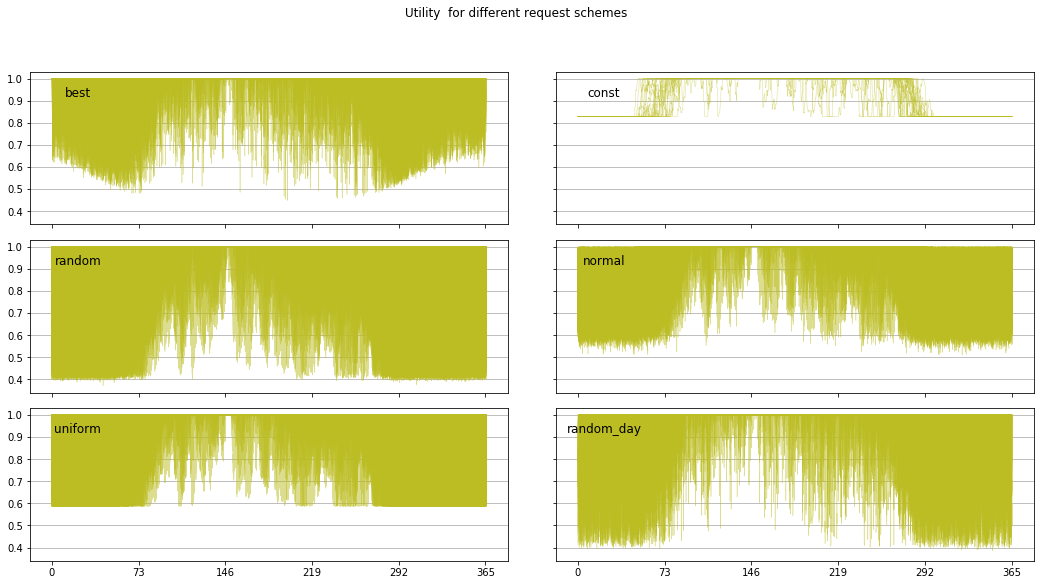

In [10]:
# For each scheme, show utility for all years
timesteps_per_day = 240
no_of_days = 365 #ignoring last days of leap years

fig, ax = plt.subplots(nrows=3,
                       ncols=2,
                       figsize=(18, 9), 
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle("Utility  for different request schemes")
counter = 0
for i in range(3):
    for j in range(2):
        scheme = scheme_list[counter]
        for yr in range(1995,2019):
            ax[i][j].plot(annual_utrace[scheme][yr],label=str(yr),color='tab:olive',alpha=0.5,linewidth=0.5)
            
            ax[i][j].yaxis.grid(True)
            ax[i][j].set_title(scheme, x=0.1, y=0.8)
#             ax[i][j].set_ylim([-0.85,0.85])
#             ax[i][j].set_xlim([0,no_of_days*timesteps_per_day])
            ax[i][j].set_xticks(np.arange(start=0,
                                          stop=timesteps_per_day*(no_of_days+1),
                                          step=timesteps_per_day*73))
            ax[i][j].set_xticklabels(np.arange(start=0,
                                               stop=no_of_days+1,
                                               step=73))

        counter += 1

In [11]:
# scheme_list = ['best','const','random', 'normal', 'uniform', 'random_day']
print("Average utility")
print("Year   best     const    random   normal   uniform  random_day")
for yr in range(1995,2019):
    print(f'{yr}',end='  ')
    for scheme in scheme_list:
        annual_umean[scheme][yr]=np.mean(annual_utrace[scheme][yr])
        print(f'{annual_umean[scheme][yr]:7.4f}',end='  ')
    print("")

Average utility
Year   best     const    random   normal   uniform  random_day
1995   0.9614   0.9256   0.9385   0.9148   0.9177   0.9382  
1996   0.9637   0.9306   0.9422   0.9205   0.9220   0.9424  
1997   0.9554   0.9175   0.9353   0.9065   0.9094   0.9354  
1998   0.9630   0.9311   0.9390   0.9206   0.9214   0.9404  
1999   0.9609   0.9238   0.9361   0.9140   0.9173   0.9350  
2000   0.9574   0.9255   0.9381   0.9144   0.9154   0.9387  
2001   0.9629   0.9263   0.9408   0.9164   0.9197   0.9424  
2002   0.9629   0.9284   0.9387   0.9177   0.9206   0.9401  
2003   0.9669   0.9331   0.9430   0.9252   0.9286   0.9416  
2004   0.9638   0.9266   0.9399   0.9171   0.9217   0.9399  
2005   0.9620   0.9288   0.9391   0.9189   0.9216   0.9394  
2006   0.9578   0.9239   0.9366   0.9133   0.9155   0.9372  
2007   0.9600   0.9242   0.9372   0.9153   0.9190   0.9370  
2008   0.9613   0.9280   0.9391   0.9186   0.9199   0.9378  
2009   0.9607   0.9227   0.9389   0.9133   0.9167   0.9401  
2010  

Text(0.5, 0, 'Year')

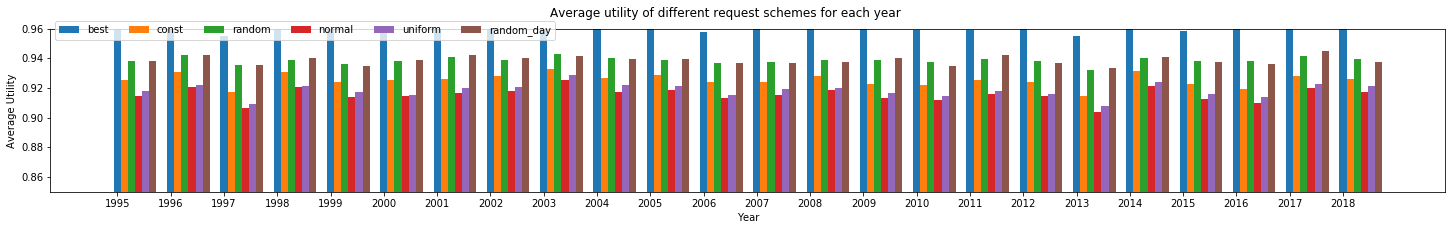

In [12]:
fig, ax = plt.subplots(1,figsize=(25,3))
fig.suptitle("Average utility of different request schemes for each year")
years = np.arange(1995,2019)

best_umean = list(annual_umean['best'].values())
const_umean = list(annual_umean['const'].values())
random_umean = list(annual_umean['random'].values())
normal_umean = list(annual_umean['normal'].values())
uniform_umean = list(annual_umean['uniform'].values())
random_day_umean = list(annual_umean['random_day'].values())

x = np.arange(len(years))  # the label locations
width = 0.8/6  # the width of the bars

best_bar = ax.bar(x + width*0, best_umean, width, label='best')
const_bar = ax.bar(x + width*1,const_umean, width, label='const')
random_bar = ax.bar(x + width*2, random_umean, width, label='random')
normal_bar = ax.bar(x + width*3, normal_umean, width, label='normal')
uniform_bar = ax.bar(x + width*4, uniform_umean, width, label='uniform')
random_day_bar = ax.bar(x + width*5, random_day_umean, width, label='random_day')

ax.legend(loc="lower left",ncol=6,bbox_to_anchor=(0,0.9,2,0.1))
ax.set_ylim(0.85,0.96)
ax.set_ylabel("Average Utility")
ax.set_xticks(np.arange(len(years)))
ax.set_xticklabels(np.arange(1995,1995+len(years)))
ax.set_xlabel("Year")



[]

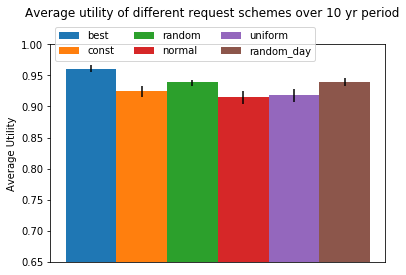

In [13]:
fig, ax = plt.subplots(1)
fig.suptitle("Average utility of different request schemes over 10 yr period",y=1.01)

best_umean = np.array(list(annual_umean['best'].values())).mean()
best_range_err = [[best_umean - min(annual_umean['best'].values())],
              [max(annual_umean['best'].values())-best_umean]]

const_umean =  np.array(list(annual_umean['const'].values())).mean()
const_range_err = [[const_umean - min(annual_umean['const'].values())],
              [max(annual_umean['const'].values()) - const_umean]]

random_umean =  np.array(list(annual_umean['random'].values())).mean()
random_range_err = [[random_umean - min(annual_umean['random'].values())],
              [max(annual_umean['random'].values())-random_umean]]

normal_umean =  np.array(list(annual_umean['normal'].values())).mean()
normal_range_err = [[normal_umean - min(annual_umean['normal'].values())],
              [max(annual_umean['normal'].values())-normal_umean]]

uniform_umean =  np.array(list(annual_umean['uniform'].values())).mean()
uniform_range_err = [[uniform_umean - min(annual_umean['uniform'].values())],
              [max(annual_umean['uniform'].values())-uniform_umean]]

random_day_umean =  np.array(list(annual_umean['random_day'].values())).mean()
random_day_range_err = [[random_day_umean - min(annual_umean['random_day'].values())],
              [max(annual_umean['random_day'].values())-random_day_umean]]
x = 0 # the label locations
width = 0.8/len(scheme_list)  # the width of the bars

best_bar = ax.bar(x + width*0, best_umean, width, yerr=best_range_err, label='best')
const_bar = ax.bar(x + width*1,const_umean, width, yerr=const_range_err, label='const')
random_bar = ax.bar(x + width*2, random_umean, width, yerr=random_range_err, label='random')
normal_bar = ax.bar(x + width*3, normal_umean, width, yerr=normal_range_err, label='normal')
uniform_bar = ax.bar(x + width*4, uniform_umean, width, yerr=uniform_range_err, label='uniform')
random_day_bar = ax.bar(x + width*5, random_day_umean, width, yerr=random_day_range_err, label='random_day')

ax.legend(loc="lower left",bbox_to_anchor=(0,0.9,1,1), ncol=3)
ax.set_ylim(0.65,1.0)
ax.set_ylabel("Average Utility")
ax.set_xticks([])
ax.set_xticklabels([])


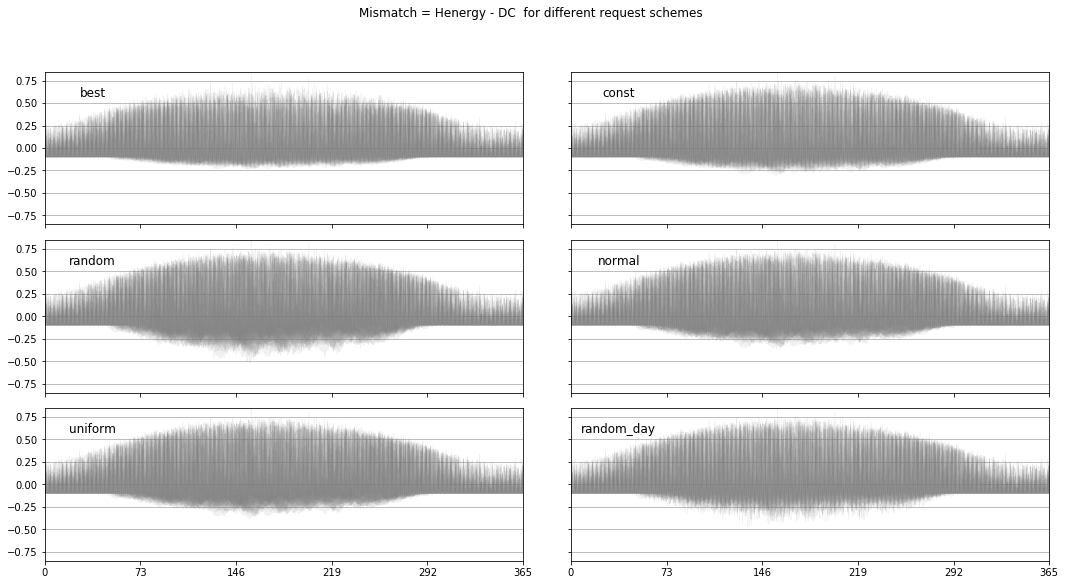

In [14]:
# For each scheme, show mismatch for all years
timesteps_per_day = 240
no_of_days = 365 #ignoring last days of leap years

fig, ax = plt.subplots(nrows=3,
                       ncols=2,
                       figsize=(18, 9), 
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle("Mismatch = Henergy - DC  for different request schemes")
counter = 0
for i in range(3):
    for j in range(2):
        scheme = scheme_list[counter]
        for yr in range(1995,2019):
            ax[i][j].plot(annual_mismatch[scheme][yr],label=str(yr),color='tab:grey',alpha=0.1,linewidth=0.5)
            
            ax[i][j].yaxis.grid(True)
            ax[i][j].set_title(scheme, x=0.1, y=0.8)
            ax[i][j].set_ylim([-0.85,0.85])
            ax[i][j].set_xlim([0,no_of_days*timesteps_per_day])
            ax[i][j].set_xticks(np.arange(start=0,
                                          stop=timesteps_per_day*(no_of_days+1),
                                          step=timesteps_per_day*73))
            ax[i][j].set_xticklabels(np.arange(start=0,
                                               stop=no_of_days+1,
                                               step=73))

        counter += 1

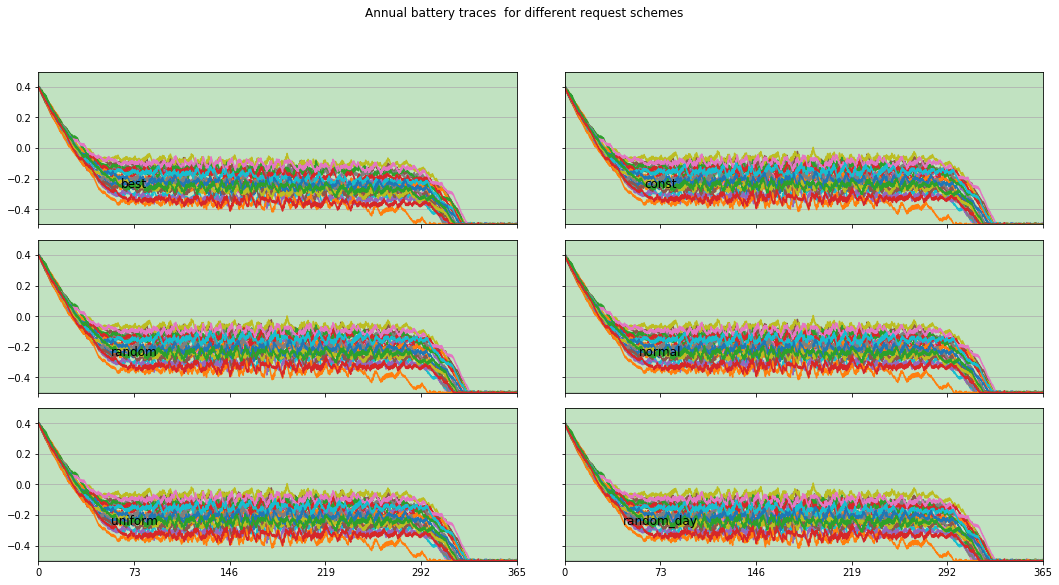

In [15]:
# For each scheme, show battery plots for all years
timesteps_per_day = 240
no_of_days = 365 #ignoring last days of leap years

fig, ax = plt.subplots(nrows=3,
                       ncols=2,
                       figsize=(18, 9), 
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle("Annual battery traces  for different request schemes")

counter = 0
for i in range(3):
    for j in range(2):
        scheme = scheme_list[counter]
        for yr in range(1995,2019):
            # permissible battery range
            ax[i][j].fill_between(x=np.arange(0,timesteps_per_day*(no_of_days+1)),
                      y1=0.5,
                      y2=-0.5,
                      color='tab:green',
                      alpha = 0.01)
            # actual battery trace
            ax[i][j].plot(annual_btrace[scheme][yr],label=str(yr))
            
            ax[i][j].yaxis.grid(True)
            ax[i][j].set_title(scheme, x=0.2, y=0.2)
            ax[i][j].set_ylim([-0.5,0.5])
            ax[i][j].set_xlim([0,no_of_days*timesteps_per_day])
            ax[i][j].set_xticks(np.arange(start=0,
                                          stop=timesteps_per_day*(no_of_days+1),
                                          step=timesteps_per_day*73))
            ax[i][j].set_xticklabels(np.arange(start=0,
                                               stop=no_of_days+1,
                                               step=73))

        counter += 1


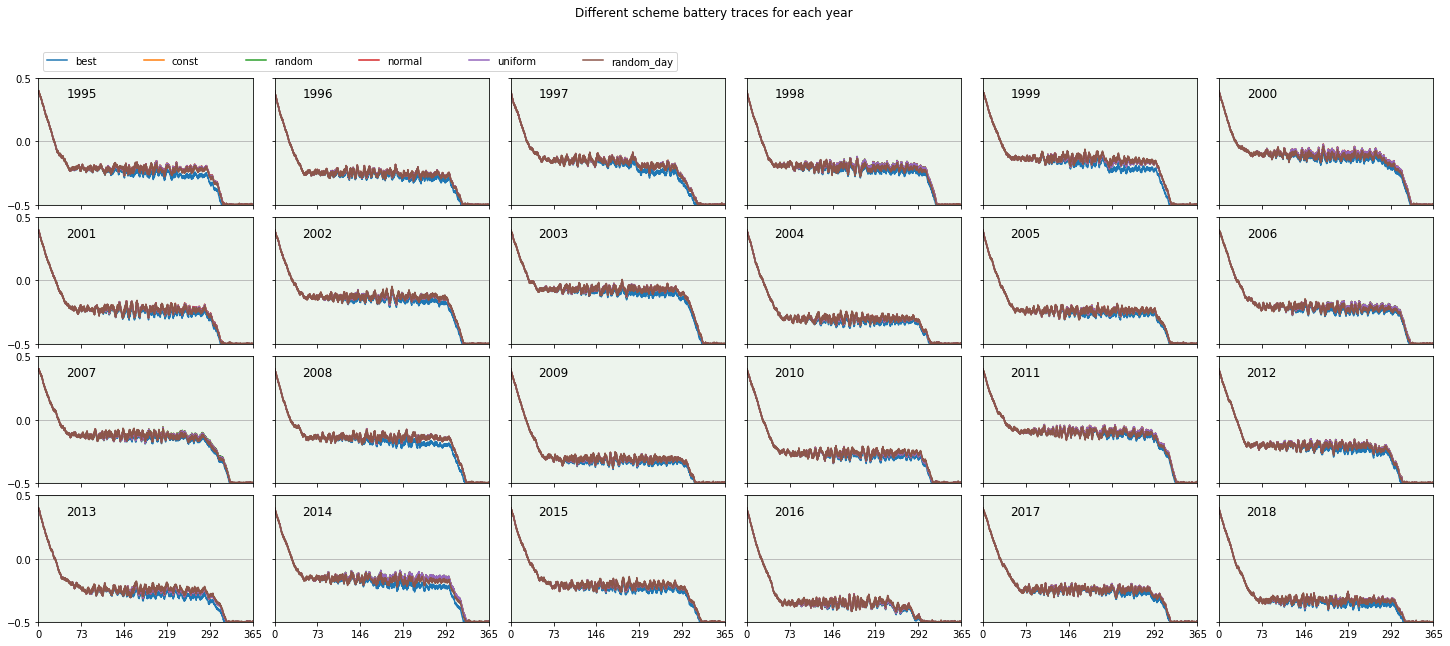

In [16]:
# For each year, show battery plots for all schemes
timesteps_per_day = 240
no_of_days = 365 #ignoring last days of leap years
no_of_rows = 4
no_of_cols = 6
fig, ax = plt.subplots(nrows=no_of_rows,
                       ncols=no_of_cols,
                       figsize=(25, 10), 
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle("Different scheme battery traces for each year")

counter = 0
for i in range(no_of_rows):
    for j in range(no_of_cols):
        yr = 1995 + counter
        for scheme in scheme_list:
            # permissible battery range
            ax[i][j].fill_between(x=np.arange(0,timesteps_per_day*(no_of_days+1)),
                      y1=0.5,
                      y2=-0.5,
                      color='tab:green',
                      alpha = 0.01)
            # actual battery trace
            ax[i][j].plot(annual_btrace[scheme][yr],label=str(scheme))
            
            ax[i][j].yaxis.grid(True)
            ax[i][j].set_title(str(yr), x=0.2, y=0.8)
            ax[i][j].set_ylim([-0.5,0.5])
            ax[i][j].set_xlim([0,no_of_days*timesteps_per_day])
            ax[i][j].set_xticks(np.arange(start=0,
                                          stop=timesteps_per_day*(no_of_days+1),
                                          step=timesteps_per_day*73))
            ax[i][j].set_xticklabels(np.arange(start=0,
                                               stop=no_of_days+1,
                                               step=73))
            ax[i][j].set_yticks([-0.5,0,0.5])
        #bbox_to_anchor = (x0, y0, width, height)
        ax[0][0].legend(loc="lower left",ncol=6,bbox_to_anchor=(0., 1.02, 3., .2),mode="expand")

        counter += 1

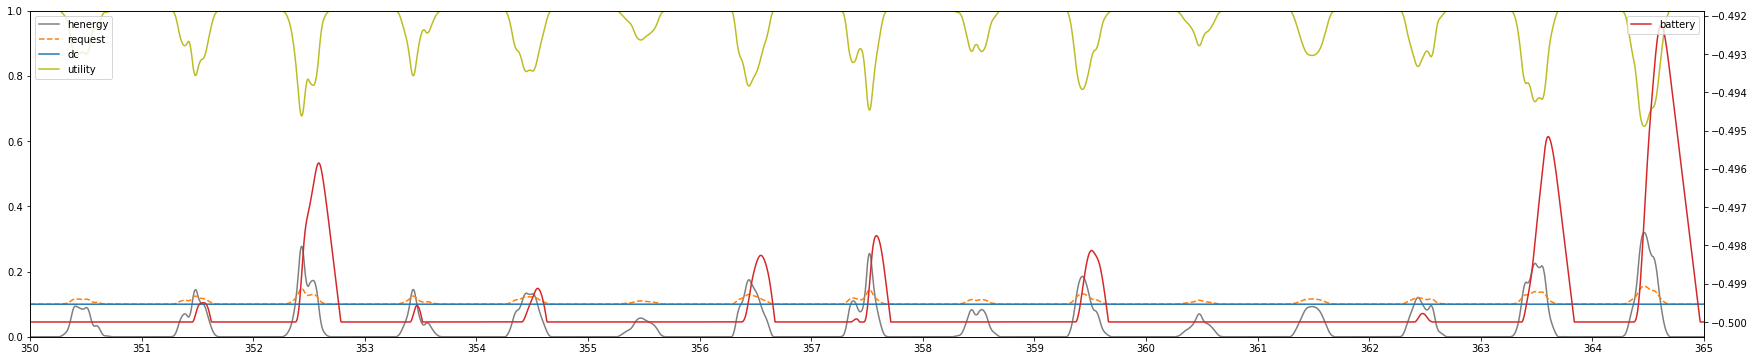

In [17]:
# Daily trace plots
yr = 2000
scheme = 'best'
timesteps_per_day = 240

start_day = 350
start_indx = start_day*timesteps_per_day
no_of_days = 15
end_indx = start_indx + int(timesteps_per_day*no_of_days)


htrace = annual_htrace[yr]
rq_trace = annual_rq_trace[scheme][yr]
dc_trace = annual_dc_trace[scheme][yr]
btrace = annual_btrace[scheme][yr]
utrace = annual_utrace[scheme][yr]
mismatch_trace = annual_mismatch[scheme][yr]



fig, ax = plt.subplots(1,figsize=(30, 6))
ax2 = ax.twinx()

ax.plot(htrace[start_indx:end_indx],   color='tab:grey', label='henergy')
ax.plot(rq_trace[start_indx:end_indx], color='tab:orange', linestyle='--', label='request')
ax.plot(dc_trace[start_indx:end_indx], color='tab:blue',  label='dc')
ax.plot(utrace[start_indx:end_indx],   color='tab:olive', label='utility')

ax2.plot(btrace[start_indx:end_indx],  color='tab:red', label='battery')
# ax2.plot(mismatch_trace[start_indx:end_indx], color='tab:cyan', label='mismatch')

ax.set_ylim([0,1])
# ax2.set_ylim([-0.5,0.5])

ax.set_xlim([0,timesteps_per_day*no_of_days])
ax.set_xticks(np.arange(start=0,
                        stop=timesteps_per_day*(no_of_days+1),
                        step=timesteps_per_day))
ax.set_xticklabels(np.arange(start=start_day,
                             stop=start_day+no_of_days+1,
                             step=1))
# ax.xaxis.grid(True)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')